In [1]:
import pandas as pd
import re
from copy import copy
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import nltk
from nltk.collocations import *
from random import choice
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
data = pd.read_csv('./hillary-clinton-emails/Emails.csv', sep=',')
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [4]:
data.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

Глянем из чего состоит текст письма.

In [46]:
data['RawText'][0].split('\n')

['UNCLASSIFIED',
 'U.S. Department of State',
 'Case No. F-2015-04841',
 'Doc No. C05739545',
 'Date: 05/13/2015',
 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.',
 'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.',
 'RELEASE IN FULL',
 'From: Sullivan, Jacob J <Sullivan11@state.gov>',
 'Sent: Wednesday, September 12, 2012 10:16 AM',
 'To:',
 'Subject: FW: Wow',
 'From: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi',
 'Sent: Wednesday, September 12, 2012 10:09 AM',
 'To: Sullivan, Jacob J',
 'Subject: Wow',
 'What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me',
 'too',
 'UNCLASSIFIED',
 'U.S. Department of State',
 'Case No. F-2015-04841',
 'Doc No. C05739545',
 'Date: 05/13/2015',
 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.',
 'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER. STATE-5CB0045247',
 '\x0c']

Видим, что в тексте письма много мусора, в котором содержится дата письма, адресат и прочее. Нас же интересует только само сообщение, поэтому попробуем удалить все лишнее построчно. Далее весь текст сконкатенируем по пробелу, раз в тексте имеются знаки препинания.

In [3]:
def clean_line(text):
    text = re.sub(r"STATE-\w+", "", text)
    text = re.sub(r"UNCLAS.*?NO FOIA WAIVER\.", "", text)
    text = re.sub(r"^UNCLASSIFIED.*$", "", text)
    text = re.sub(r"^PART \w+$", "", text)
    text = re.sub(r"^RELEASE IN\s{0,1}\w*$", "", text)
    text = re.sub(r"^RELEASE IN PART\s{0,1}\w*$", "", text)
    text = re.sub(r"^From:.*$", "", text)
    text = re.sub(r"^Sent:.*$", "", text)
    text = re.sub(r"^To:.*$", "", text)
    text = re.sub(r"^Cc:.*$", "", text)
    text = re.sub(r"^Subject:.*$", "", text)
    text = re.sub(r"^B\d{1}$", "", text)
    text = re.sub(r"^Case No.*$", "", text)
    text = re.sub(r"^Doc No.*$", "", text)
    text = re.sub(r"^Date:.*$", "", text)
    text = re.sub(r"^U\.S\. Department of State.*$", "", text)
    text = re.sub(r"^[-—]*\s{0,1}Original Message\s{0,1}[-—]*$", "", text)
    text = re.sub(r"^STATE DEPT\..*$", "", text)
    text = re.sub(r"UNCLASSIFIED.*$", "", text)
    text = re.sub(r"CONFIDENTIAL.*$", "", text) 
    text = re.sub(r"^SUBJECT TO AGREEMENT.*$", "", text)
    text = re.sub(r"^For.*$", "", text)
    text = re.sub(r"^Fw.*$", "", text)
    text = re.sub(r"^.*SENSITIVE BUT UNCLASSIFIED.*$", "", text)
    text = re.sub(r"^Importance.*$", "", text)
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', text)
    return text

def clean_text(msg):
    lines = msg.split('\n')
    clean_lines = []
    for line in lines:
        res = clean_line(line)
        if res:
            clean_lines.append(res)
    return ' '.join(clean_lines)

In [50]:
clean_text(data['RawText'][1])

"Attachments: Thursday, March 3, 2011 9:45 PM H: Latest How Syria is aiding Qaddafi and more... Sid hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx March 3, 2011 Re: Syria aiding Qaddafi This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It seems that the situation is developing into a protracted civil war with various nations backing opposing sides with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his strategic depth—his support both financial and military. I. Report During the afternoon of March 3, advisers to Muammar Qaddafi stated privately that the Libyan Leader has decided that civil war is inevitable, pitting troops and mercenary troops loyal to him against the rebel forces gathering around Benghazi. Qaddafi is convinced that 

Вроде бы получилось более менее, остался только текст самого сообщения с некоторыми добавлениями. Обработаем так все имеющиеся тексты.

In [4]:
%%time
processed_texts = [clean_text(text) for text in data['RawText']]

CPU times: user 12.6 s, sys: 4 ms, total: 12.6 s
Wall time: 12.6 s


Посмотрим на самые частые биграммы.

In [ ]:
import sklearn.feature_extraction.text
from nltk.tokenize import TreebankWordTokenizer

ngram_size = 2
string = ["I really like python, it's pretty awesome."]
vect = CountVectorizer(ngram_range=(ngram_size,ngram_size), \
                                                 tokenizer=TreebankWordTokenizer().tokenize)
X = vect.fit_transform(processed_texts)

In [89]:
X = X.tocsc()

In [90]:
import sys

def dynamic_print(string):
    sys.stdout.write('\r{}'.format(string))

frequencies = {}
for bigram_index in range(X.shape[1]):
    frequencies[bigram_index] = np.sum(X[:, bigram_index])
    if bigram_index % 100:
        dynamic_print(bigram_index)

562975

In [99]:
frequencies = sorted(frequencies.items(), key=lambda x: -x[1])

In [103]:
bigrams = vect.get_feature_names()
for index, freq in frequencies[:30]:
    print(bigrams[index], freq)

of the 13775
in the 10046
, and 8897
to the 6390
, the 6215
on the 5030
and the 4269
for the 4023
that the 3542
, but 3232
with the 3211
, '' 3118
to be 3024
at the 2882
by the 2417
will be 2398
http : 2169
from the 2151
it is 2151
is a 2114
, a 2071
, i 2046
the united 2038
in a 1908
as a 1875
of a 1836
has been 1732
united states 1717
, which 1624
we are 1605


В принципе результаты довольно ожидаемы, в топе: of the, in the

Найдем теперь коллокации.

In [105]:
import nltk
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()
text = " ".join(processed_texts)
finder = BigramCollocationFinder.from_words(text.split())
finder.apply_freq_filter(200)
finder.nbest(bigram_measures.pmi, 30) 

[('Sullivan,', 'Jacob'),
 ('Northern', 'Ireland'),
 ('Private', 'Residence'),
 ('SECRETARY', 'CLINTON:'),
 ('*En', 'route'),
 ('RELEASE', 'IN'),
 ('IN', 'PART'),
 ('Conference', 'Room'),
 ('Mills,', 'Cheryl'),
 ('Middle', 'East'),
 ('Washington,', 'DC'),
 ('Cheryl', 'D'),
 ('human', 'rights'),
 ('New', 'York'),
 ('health', 'care'),
 ('Subject', 'Fw:'),
 ('Prime', 'Minister'),
 ('White', 'House'),
 ("Secretary's", 'Office'),
 ('United', 'States'),
 ('United', 'Nations'),
 ('Let', 'me'),
 ('rather', 'than'),
 ('pm', 'DEPART'),
 ('pm', 'ARRIVE'),
 ('Subject', 'Re:'),
 ('State', 'Department'),
 ('Hillary', 'Clinton'),
 ('Foreign', 'Minister'),
 ('foreign', 'policy')]

Получились неплохие коллокации, например Washingto DC, United States, United Nations, State Departement. То есть биграмы, в которых отдельные слова встречаются реже, чем их комбинация.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000)
features = vectorizer.fit_transform(processed_texts)

In [6]:
%%time

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_jobs=-1)
kmeans.fit(features)

CPU times: user 328 ms, sys: 52 ms, total: 380 ms
Wall time: 1min 2s


In [7]:
y = kmeans.predict(features)

In [ ]:
processed_texts = np.array(processed_texts)

In [9]:
for cluster in range(3):
    for ex in range(3):
        print(processed_texts[y == cluster][ex])
        print("-------")
    print("-------")

What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me too
-------
To Mills, Cheryl D Subject FW: Cairo Condemnation - Final FYI - To Schwartz, Larry; Ranz, David J; Sievers, Marc 3; Linfield, David E; Sayles, Ambrose G; NEA-Press-DL; NEA-Egypt; Shea, Peter T All, ADS Aaron D. Snipe Spokesperson I Bureau of Near Eastern Affairs I U.S. Department of State UNCLASSIFIF81 C Street NW I Room 6250 I Washington, DC, 20520 Office: +1 202-647-9533 I Email: snipead@state.gov Sent Tuesday, September 11, 2012 5:26 AM To Ranz, David J; Sievers, Marc J; Linfield, David E; Sayles, Ambrose G; NEA-Press-DL; NEA-Egypt; Shea, Peter T cc: Mitchell, Andrew B Subject Cairo Condemnation - Final
-------
Sent Subject Pis print. -•-...-^ H < hrod17@clintonernailcom> Wednesday, September 12, 2012 2:11 PM Russorv@state.gov' From [meat) htte/maxbiumenthal.com12012/09/meet-the-right-wing-extremist-behind-anti-musiim-tihn-that-sparked- deadly-riots/ Sent f

Последний кластер про Кадаффи, первые два не очень интерпретируемы.

In [8]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE()
X_tsne = tsne.fit_transform(features.todense())

CPU times: user 4min 59s, sys: 9.56 s, total: 5min 9s
Wall time: 4min 57s


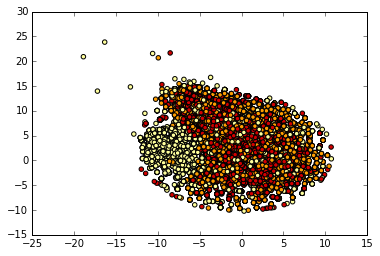

In [10]:
num_classes = 3
color_dict = cm.hot(np.linspace(0.3, 0.9, num_classes))
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=color_dict[y])
plt.show()

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features.todense())

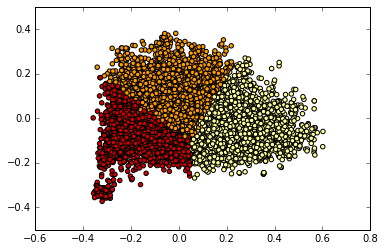

In [13]:
num_classes = 3
color_dict = cm.hot(np.linspace(0.3, 0.9, num_classes))
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=color_dict[y])
plt.show()

In [15]:
import mpld3

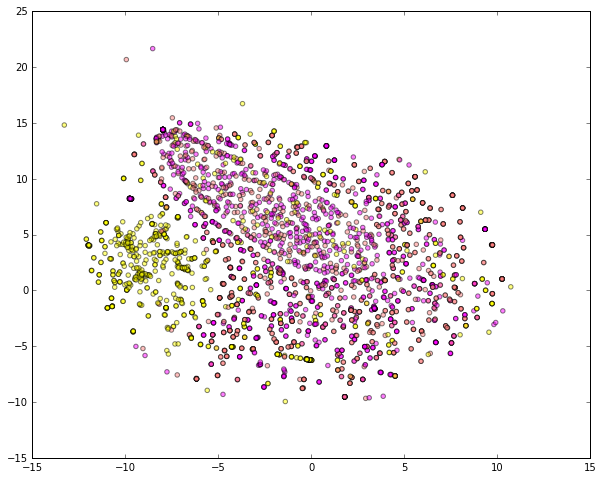

In [16]:
mpld3.enable_notebook()
color = np.linspace(0.0, 1, 3)
fig, ax = plt.subplots(figsize=(10, 8))
scat = ax.scatter(X_tsne[:3000, 0], X_tsne[:3000, 1], c=color[y][:3000], cmap=plt.cm.spring, alpha=0.5)
tooltip = mpld3.plugins.PointLabelTooltip(scat, labels=list(map(str, y[:3000])))
mpld3.plugins.connect(fig, tooltip)
plt.show()